In [1]:
from IPython.display import display

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F

In [2]:
matplotlib.rc('animation', html='jshtml')

In [3]:
data = np.load('data/class130-actions-segment80_shift16-coords_normPOS-fps12.npz')
sample_ids, subsequences = data['sample_ids'], data['subsequences']

In [4]:
subsequences.shape

(28023, 8, 31, 3)

In [5]:
minX, minY, minZ = subsequences.min(axis=(0, 1, 2))
maxX, maxY, maxZ = subsequences.max(axis=(0, 1, 2))

In [6]:
def visualize_pose(ax, seqs, frame):
    edges = (
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), # leg
        (0, 6), (6, 7), (7, 8), (8, 9), (9, 10), # leg
        (0, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), # torso + head
        (13, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (20, 23), # hand
        (13, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (27, 30) # hand
    )
    
    artists = []
    colors = ('b', 'r', 'g')
    for n, seq in enumerate(seqs):
        for start, end in edges:
            x0, y0, z0 = seq[frame, start]
            x1, y1, z1 = seq[frame, end]
            artist = ax.plot([x0, x1], [y0, y1], [z0, z1], c=colors[n], zdir='x')
            artists.extend(artist)
    
    return artists


def prepare_animation(ax, seqs):
    
    def animate(i):
        ax.clear()
        ax.set(xlim=(minX, maxX), xticks=[],
               ylim=(minY, maxY), yticks=[],
               zlim=(minZ, maxZ), zticks=[])
        ax.grid(False)
        return visualize_pose(ax, seqs, i)
    
    return animate


def visualize_sequences(seqs):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ani = animation.FuncAnimation(fig, prepare_animation(ax, seqs), seqs.shape[1], repeat=False, blit=True)
    plt.show()
    plt.close()
    display(ani)

<IPython.core.display.Javascript object>


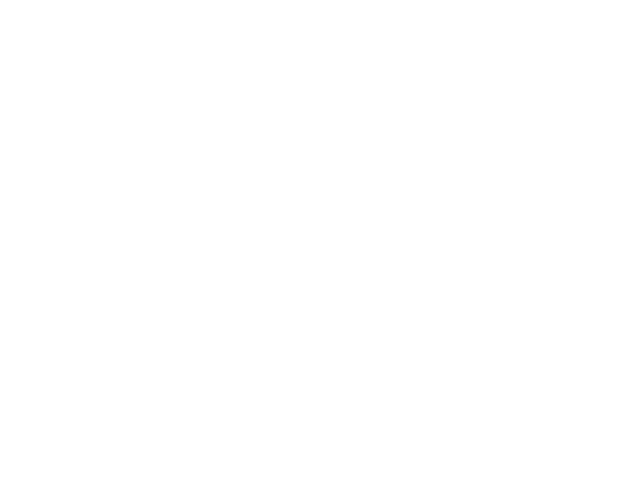

In [7]:
seqs = subsequences[[928]]
visualize_sequences(seqs)

In [8]:
import torch
from train import LitVAE
from datamodules import MoCapDataModule

In [55]:
#model = LitVAE.load_from_checkpoint('lightning_logs/version_2/checkpoints/epoch=29-step=72990.ckpt')
model = LitVAE.load_from_checkpoint('runs/class130-actions-segment80_shift16-coords_normPOS-fps12/lightning_logs/version_0/checkpoints/epoch=98-step=3861.ckpt')
model = model.eval()

In [56]:
seq = subsequences[[56]]

In [57]:
with torch.no_grad():
    x = torch.from_numpy(seq)
    _, n_frames, joints, _ = x.shape

    x = x.flatten(start_dim=2)  # B x T x (J*3)
    x = x.swapaxes(1, 2)  # B x (J*3) x T

    x_encoded = model.encoder(x).flatten(start_dim=1)
    mu, log_var = model.fc_mu(x_encoded), model.fc_var(x_encoded)

    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    z = z.unsqueeze(-1)
    x_hat = model.decoder(z)
    x_hat = x_hat.swapaxes(1, 2)
    print(x_hat.shape)
    x_hat = x_hat.reshape(1, n_frames, joints, -1)
    x_hat = x_hat.numpy()

torch.Size([1, 8, 93])


In [58]:
with torch.no_grad():
    x = torch.from_numpy(seq)
    mu, std = model.encode(x)

    x_hat = model.decode(mu)

<IPython.core.display.Javascript object>


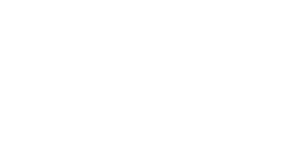

In [59]:
seqs = np.concatenate([seq, x_hat])
visualize_sequences(seqs)

In [60]:
dm = MoCapDataModule('data/class130-actions-segment80_shift16-coords_normPOS-fps12.data', batch_size=80)
dm.prepare_data()
dm.setup()
trainer = pl.Trainer()
features = trainer.predict(model, dataloaders=dm.test_dataloader())

# with torch.no_grad():
#     features = [model.encode(x)[0].numpy() for x in tqdm(loader)]
    

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_dataset len: 19464
valid_dataset len: 4198
test_dataset len: 4361
predict_dataset len: 28023


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [61]:
features = torch.cat(features, 0)
features = F.normalize(features)
sim_mat = torch.matmul(features, features.T)

In [62]:
features.shape

torch.Size([4361, 8])

In [63]:
dm.test_ids

array(['3234_98_963_331_0', '3234_98_963_331_1', '3234_98_963_331_2', ...,
       '3192_72_966_240_8', '3192_72_966_240_9', '3192_72_966_240_10'],
      dtype='<U21')

In [64]:
test_sequences = dm.test_dataset.tensors[0].numpy()

In [65]:
knns = sim_mat.numpy().argsort(axis=1)[:, -3:][:, ::-1]

[  54 1596 2749]


<IPython.core.display.Javascript object>


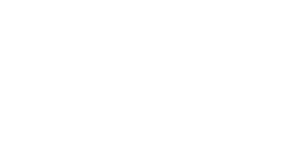

In [66]:
query_idx = 54
nns_idx = knns[query_idx]
print(nns_idx)
nns = test_sequences[nns_idx]
visualize_sequences(nns)

In [87]:
import os
from pathlib import Path

import pandas as pd

root = Path('runs/class130-actions-segment80_shift16-coords_normPOS-fps12/lightning_logs/')

for i in range(6):
    run_dir = root / f'version_{i}'
    a = pd.read_csv(run_dir / 'predictions.csv')
    out = run_dir / 'predictions.data'
    
    dim = len(a.columns) - 1
    a[['seq_id', 'frame']] = a.id.str.rsplit('_', 1, expand=True)
    
    with open(out, 'w') as f:
        for seq_id, group in a.groupby('seq_id'):
            print(f'#objectKey messif.objects.keys.AbstractObjectKey {seq_id}', file=f)
            print(f'{len(group)};mcdr.objects.ObjectMocapPose', file=f)
            print(group.loc[:, '0':f'{dim-1}'].to_csv(index=False, header=False), end='', file=f)
    
    for split in ('train', 'valid', 'test'):
        inp = run_dir / f'{split}_ids.txt'
        outp = run_dir / f'{split}_ids_seqs.txt'
        os.system(f'cat {inp} | rev | cut -d_ -f2- | rev | uniq > {outp}')